In [1]:
# Import statements:
import numpy as np
import scipy.linalg
from scipy.linalg import expm
import matplotlib.pyplot as plt
from matplotlib import rc
import scipy.constants as cnst
import schemdraw
import schemdraw.elements as elm
from PIL import Image
import h5py

In [2]:
plt.rcParams.update({'font.size': 8})
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

# Figure 3.1

This figure should contain the Caldeira-Legget circuit representation of an open quantum system.

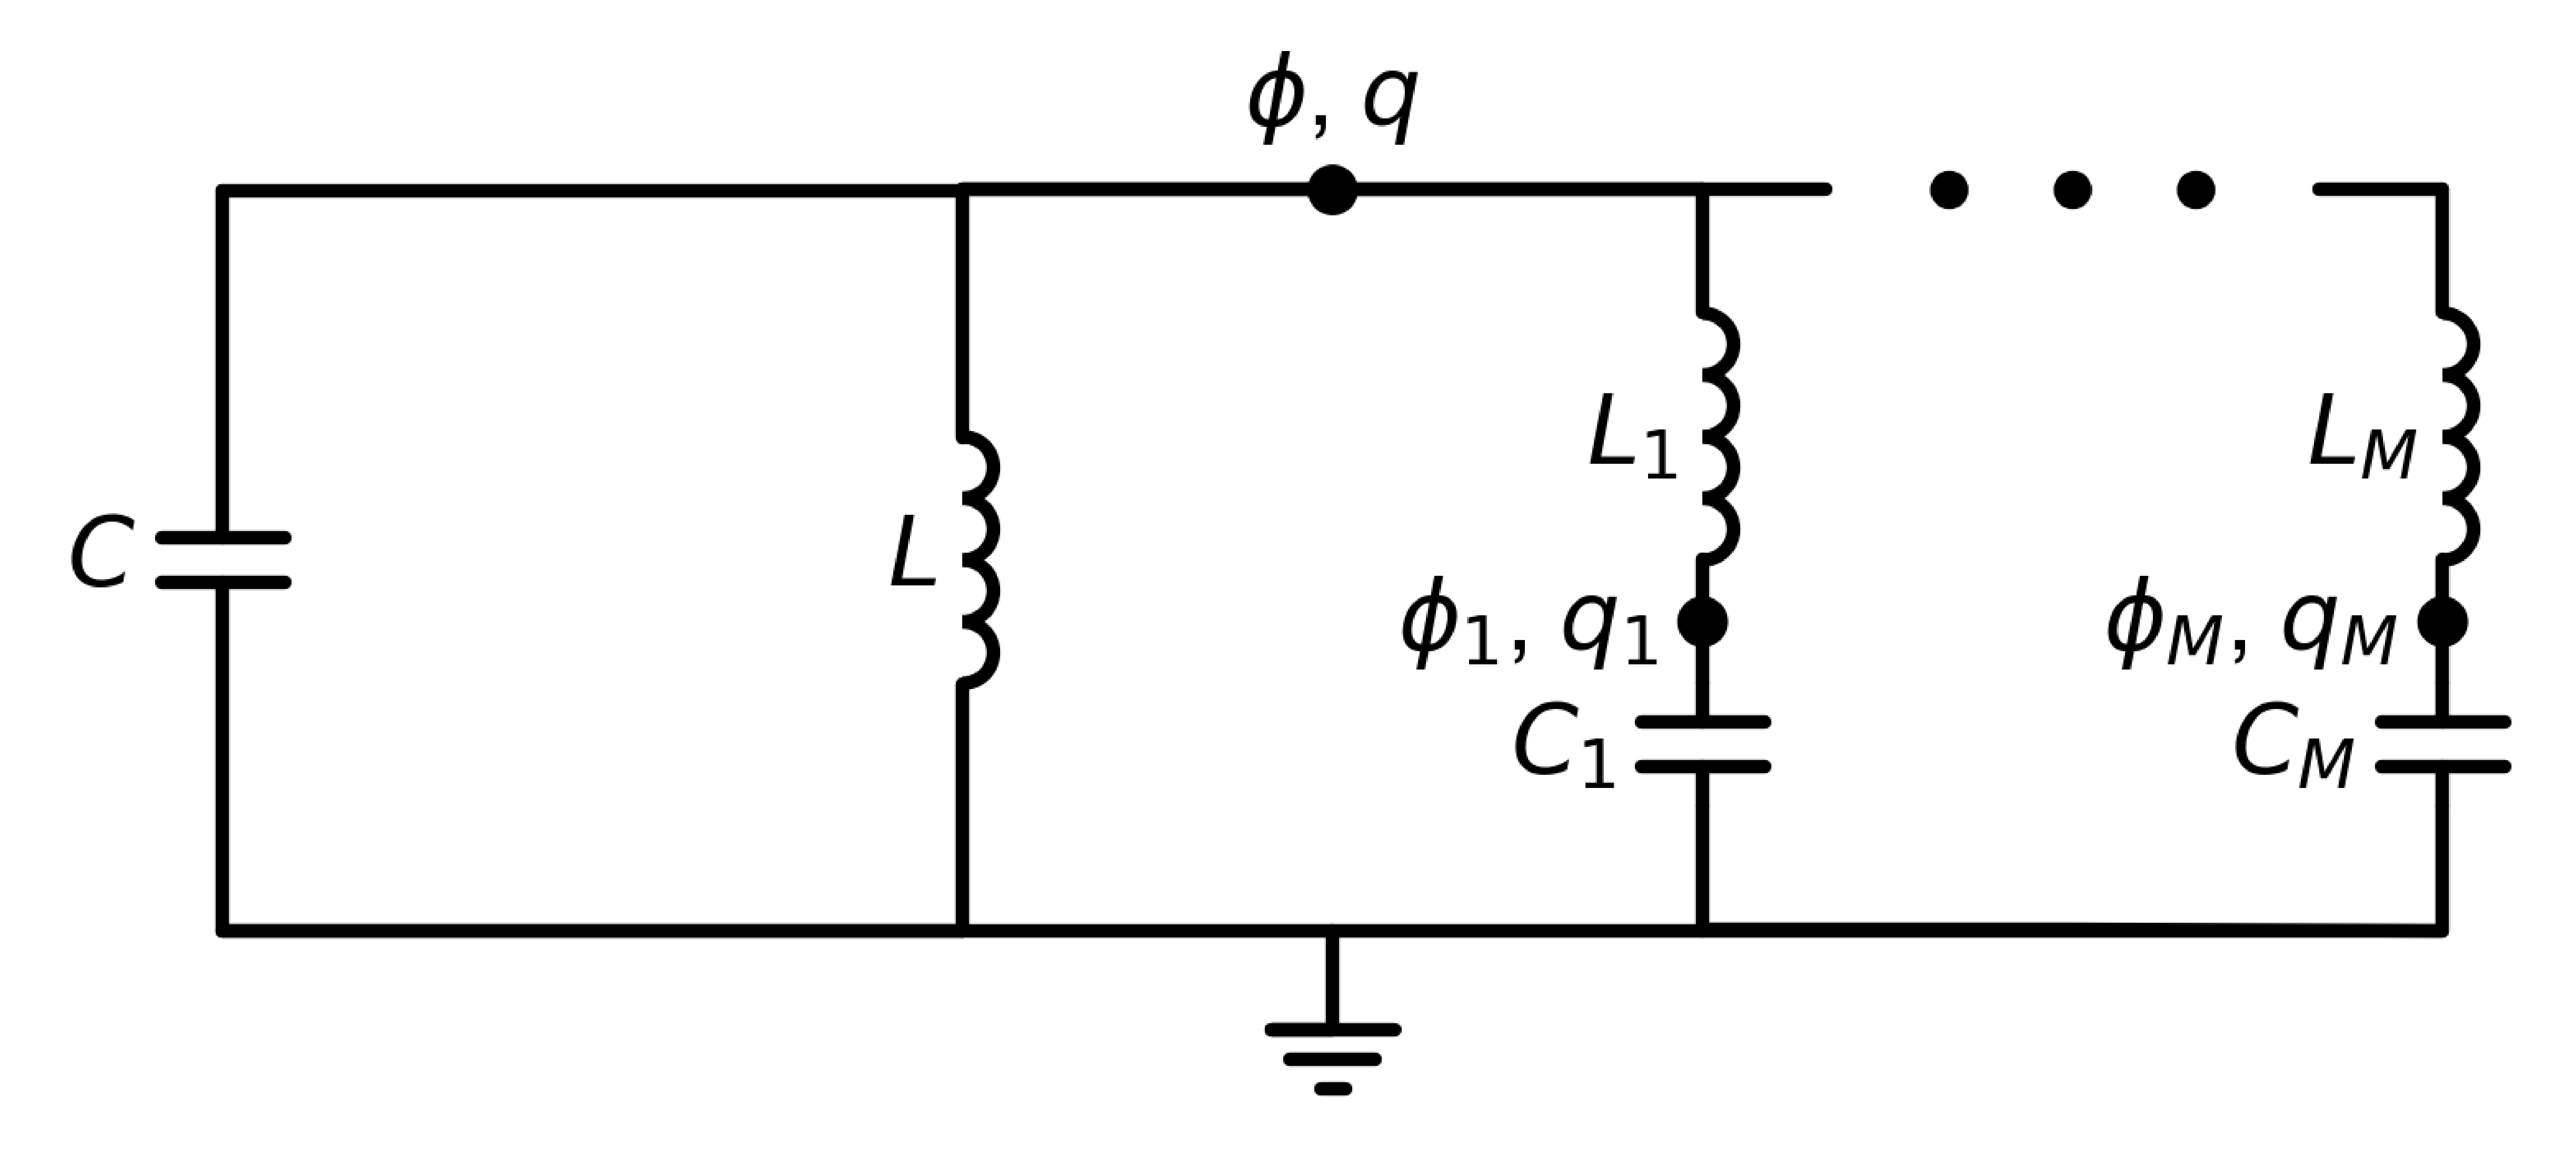

In [55]:
# Create a new drawing
d = schemdraw.Drawing()

d += elm.Capacitor().up().label("$C$")
d += elm.Line().right()
d += elm.Inductor().down().label("$L$")
d += elm.Line().left()
d += elm.Line().right()
# groundLine = elm.Line().right()
# d += groundLine
# ground = elm.Ground()
# ground.at(groundLine.center)
# d += ground
d += elm.Line().right().length(1.5)
d += elm.Ground()
d += elm.Line().right().length(1.5)
d += elm.Line().right()
d += elm.Line().left()
d += elm.Line().up().length(0.5)
d += elm.Capacitor().up().label("$C_1$").length(0.5)
d += elm.Line().up().length(0.25)
d += elm.Dot().label("$\phi_1$, $q_1$", loc = "left")
d += elm.Line().up().length(0.25)
d += elm.Gap().up().length(0.5)
d += elm.Inductor().down().label("$L_1$").length(0.5)
d += elm.Gap().up().length(0.5)
d += elm.Line().up().length(0.5)
d += elm.Line().left()
d += elm.Line().right().length(1.5)
d += elm.Dot().label("$\phi$, $q$", loc = "top")
d += elm.Line().right().length(1.5)

d += elm.Line().right().length(0.5)
d += elm.Line().right().length(0.5).color('none')
d += elm.Dot(radius=0.05)
d += elm.Line().right().length(0.5).color('none')
d += elm.Dot(radius=0.05)
d += elm.Line().right().length(0.5).color('none')
d += elm.Dot(radius=0.05)
d += elm.Line().right().length(0.5).color('none')
d += elm.Line().right().length(0.5)

d += elm.Line().down().length(0.5)
d += elm.Inductor().down().label("$L_M$").length(0.5)
d += elm.Line().down().length(0.25)
d += elm.Dot().label("$\phi_M$, $q_M$", loc = "left")
d += elm.Line().down().length(0.25)
d += elm.Capacitor().down().label("$C_M$").length(0.5)
d += elm.Line().down().length(0.5)


d.draw()

d.save("caldeiraLegget.png", dpi=300)

# Load the saved image and integrate it into a matplotlib figure
img = Image.open("caldeiraLegget.png")

fig, ax = plt.subplots(figsize=(6.5, 3.25), dpi=1000)

ax.imshow(img)
ax.axis('off')  # Hide axes for a clean look
plt.tight_layout()
plt.savefig("fig3p1.pdf")

# Figure 3.2

This figure should contain a transmon capacitively coupled to a readout resonator.

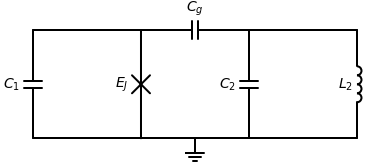

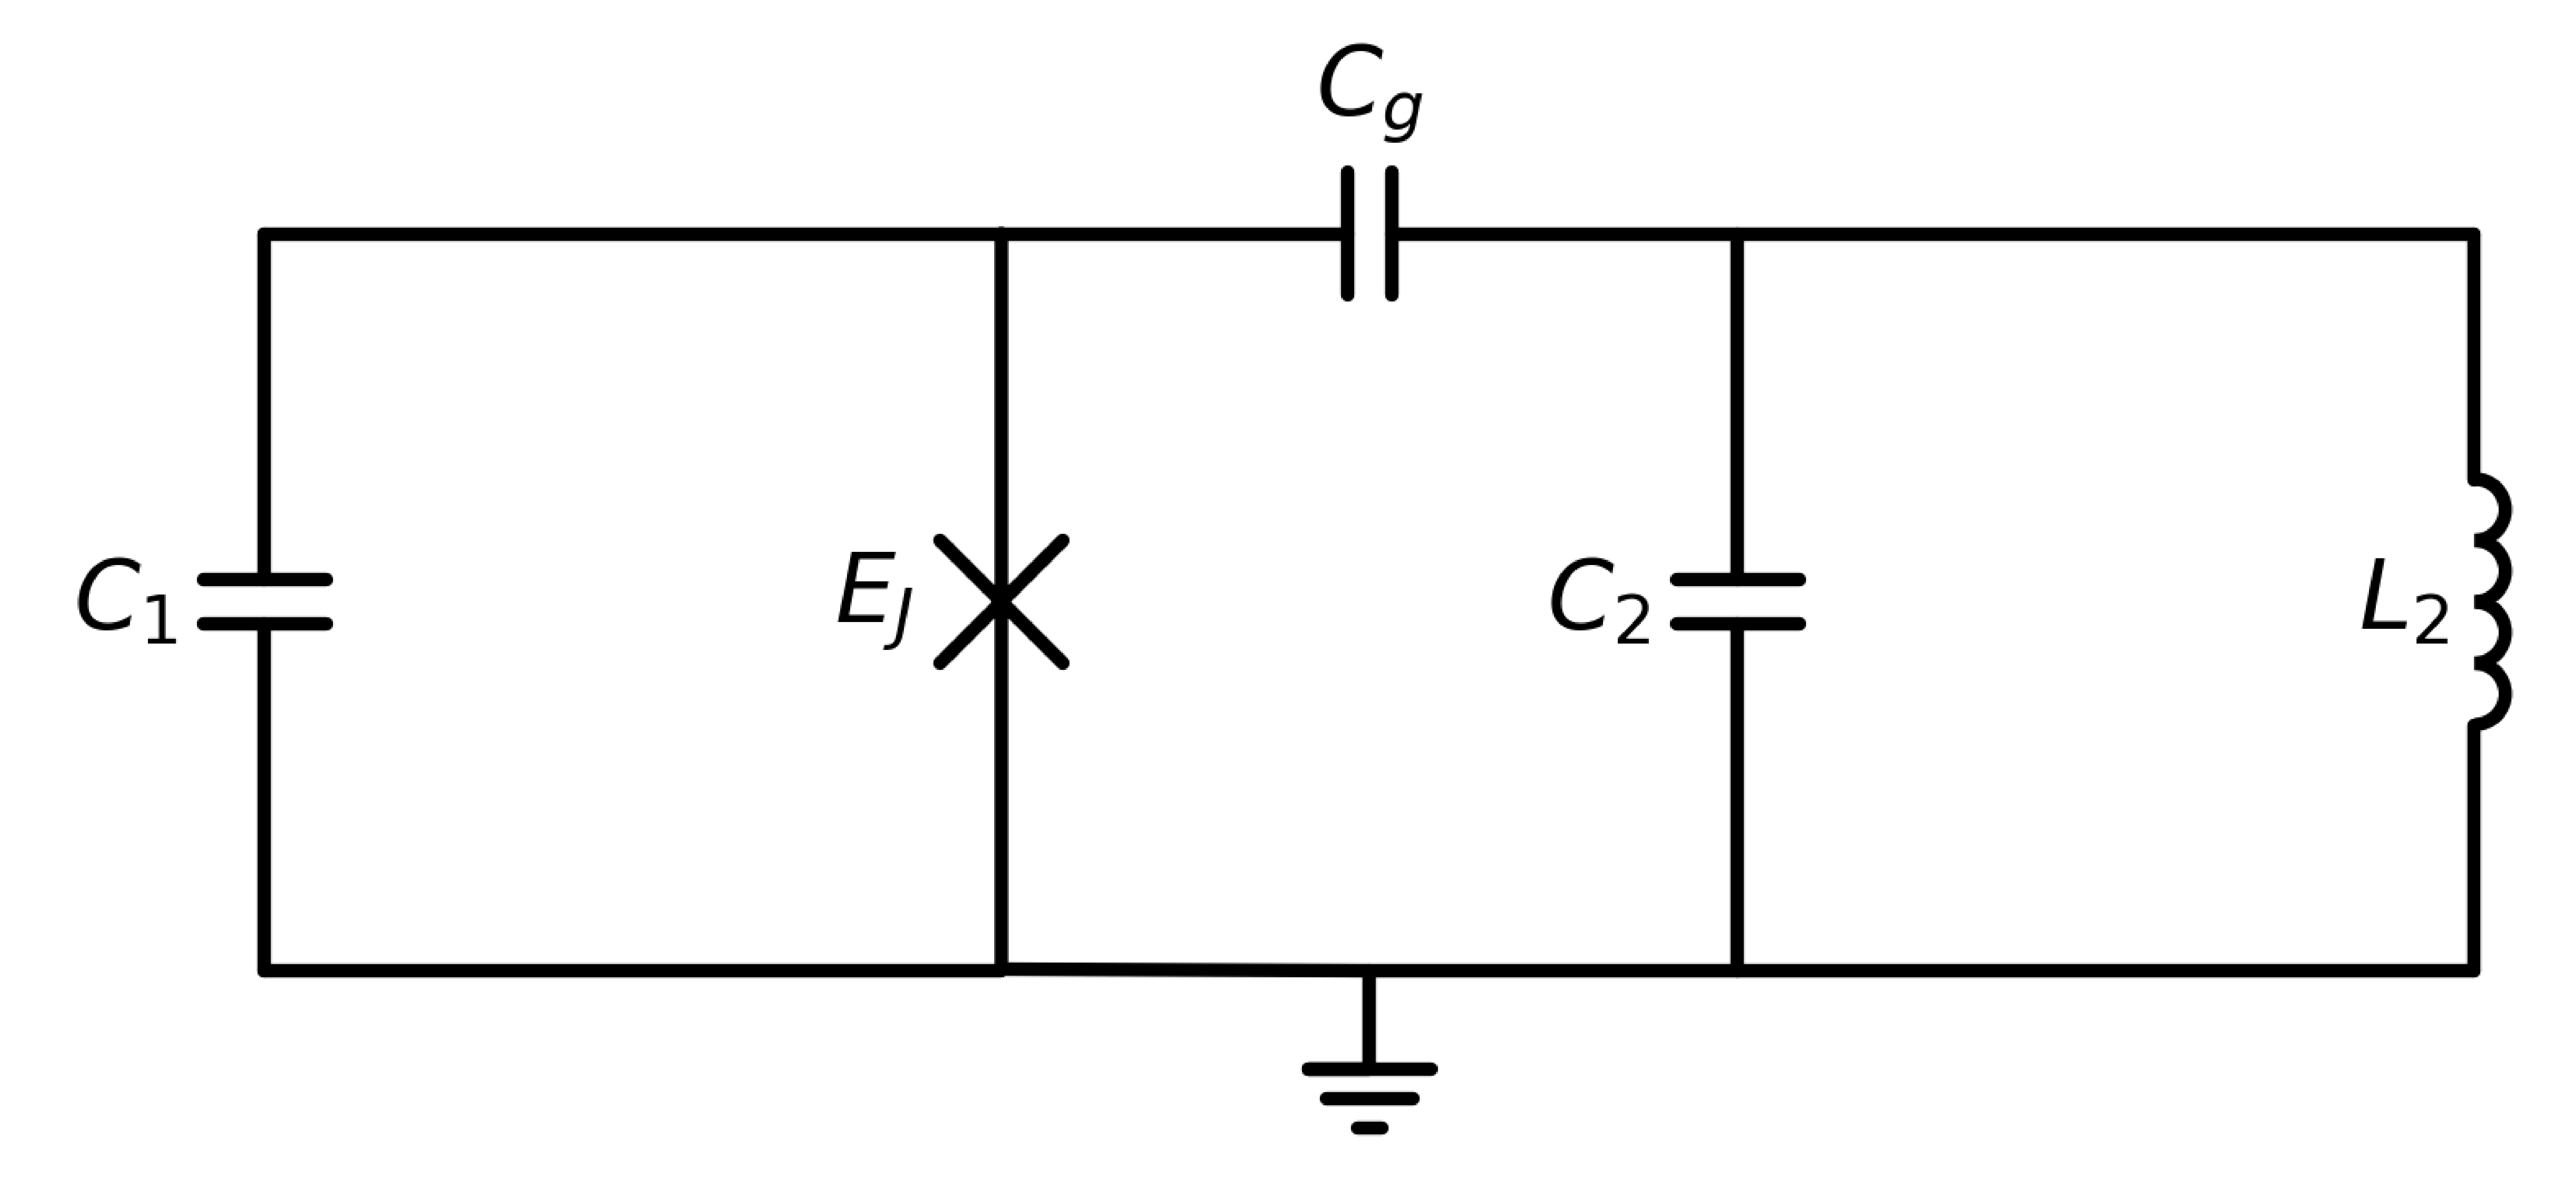

In [56]:
fig, ax = plt.subplots(figsize=(6.5, 3.25), dpi=1000)

with schemdraw.Drawing() as d:
    # Left resonator (qubit):
    d += elm.Capacitor().up().label("$C_1$")  # Gap element to create spacing
    d += elm.Line().right()
    d += elm.Josephson().down().label("$E_J$")
    d += elm.Line().left()
    d += elm.Gap().up()
    d += elm.Gap().right()
    # Coupler:
    d += elm.Capacitor().right().label("$C_g$")
    # Right resonator (qubit):
    d += elm.Line().right()
    d += elm.Inductor().down().label("$L_2$")
    d += elm.Line().left()
    d += elm.Capacitor().up().label("$C_2$")
    d += elm.Gap().down()
    # Ground:
    groundLine = elm.Line().left()
    d += groundLine
    ground = elm.Ground()
    ground.at(groundLine.center)
    d += ground
    d.draw()
    d.save("jcCircuit.png", dpi=300)  # Change dpi to your desired resolution
    
    
# Load the saved image and integrate it into a matplotlib figure
img = Image.open('jcCircuit.png')

ax.imshow(img)
ax.axis('off')  # Hide axes for a clean look

plt.tight_layout()

fig.savefig('fig3p2.pdf')

# Figure 3.3

This figure should display the n matrix elements of the transmon Hamiltonian (Fig 7 of Koch 2007).

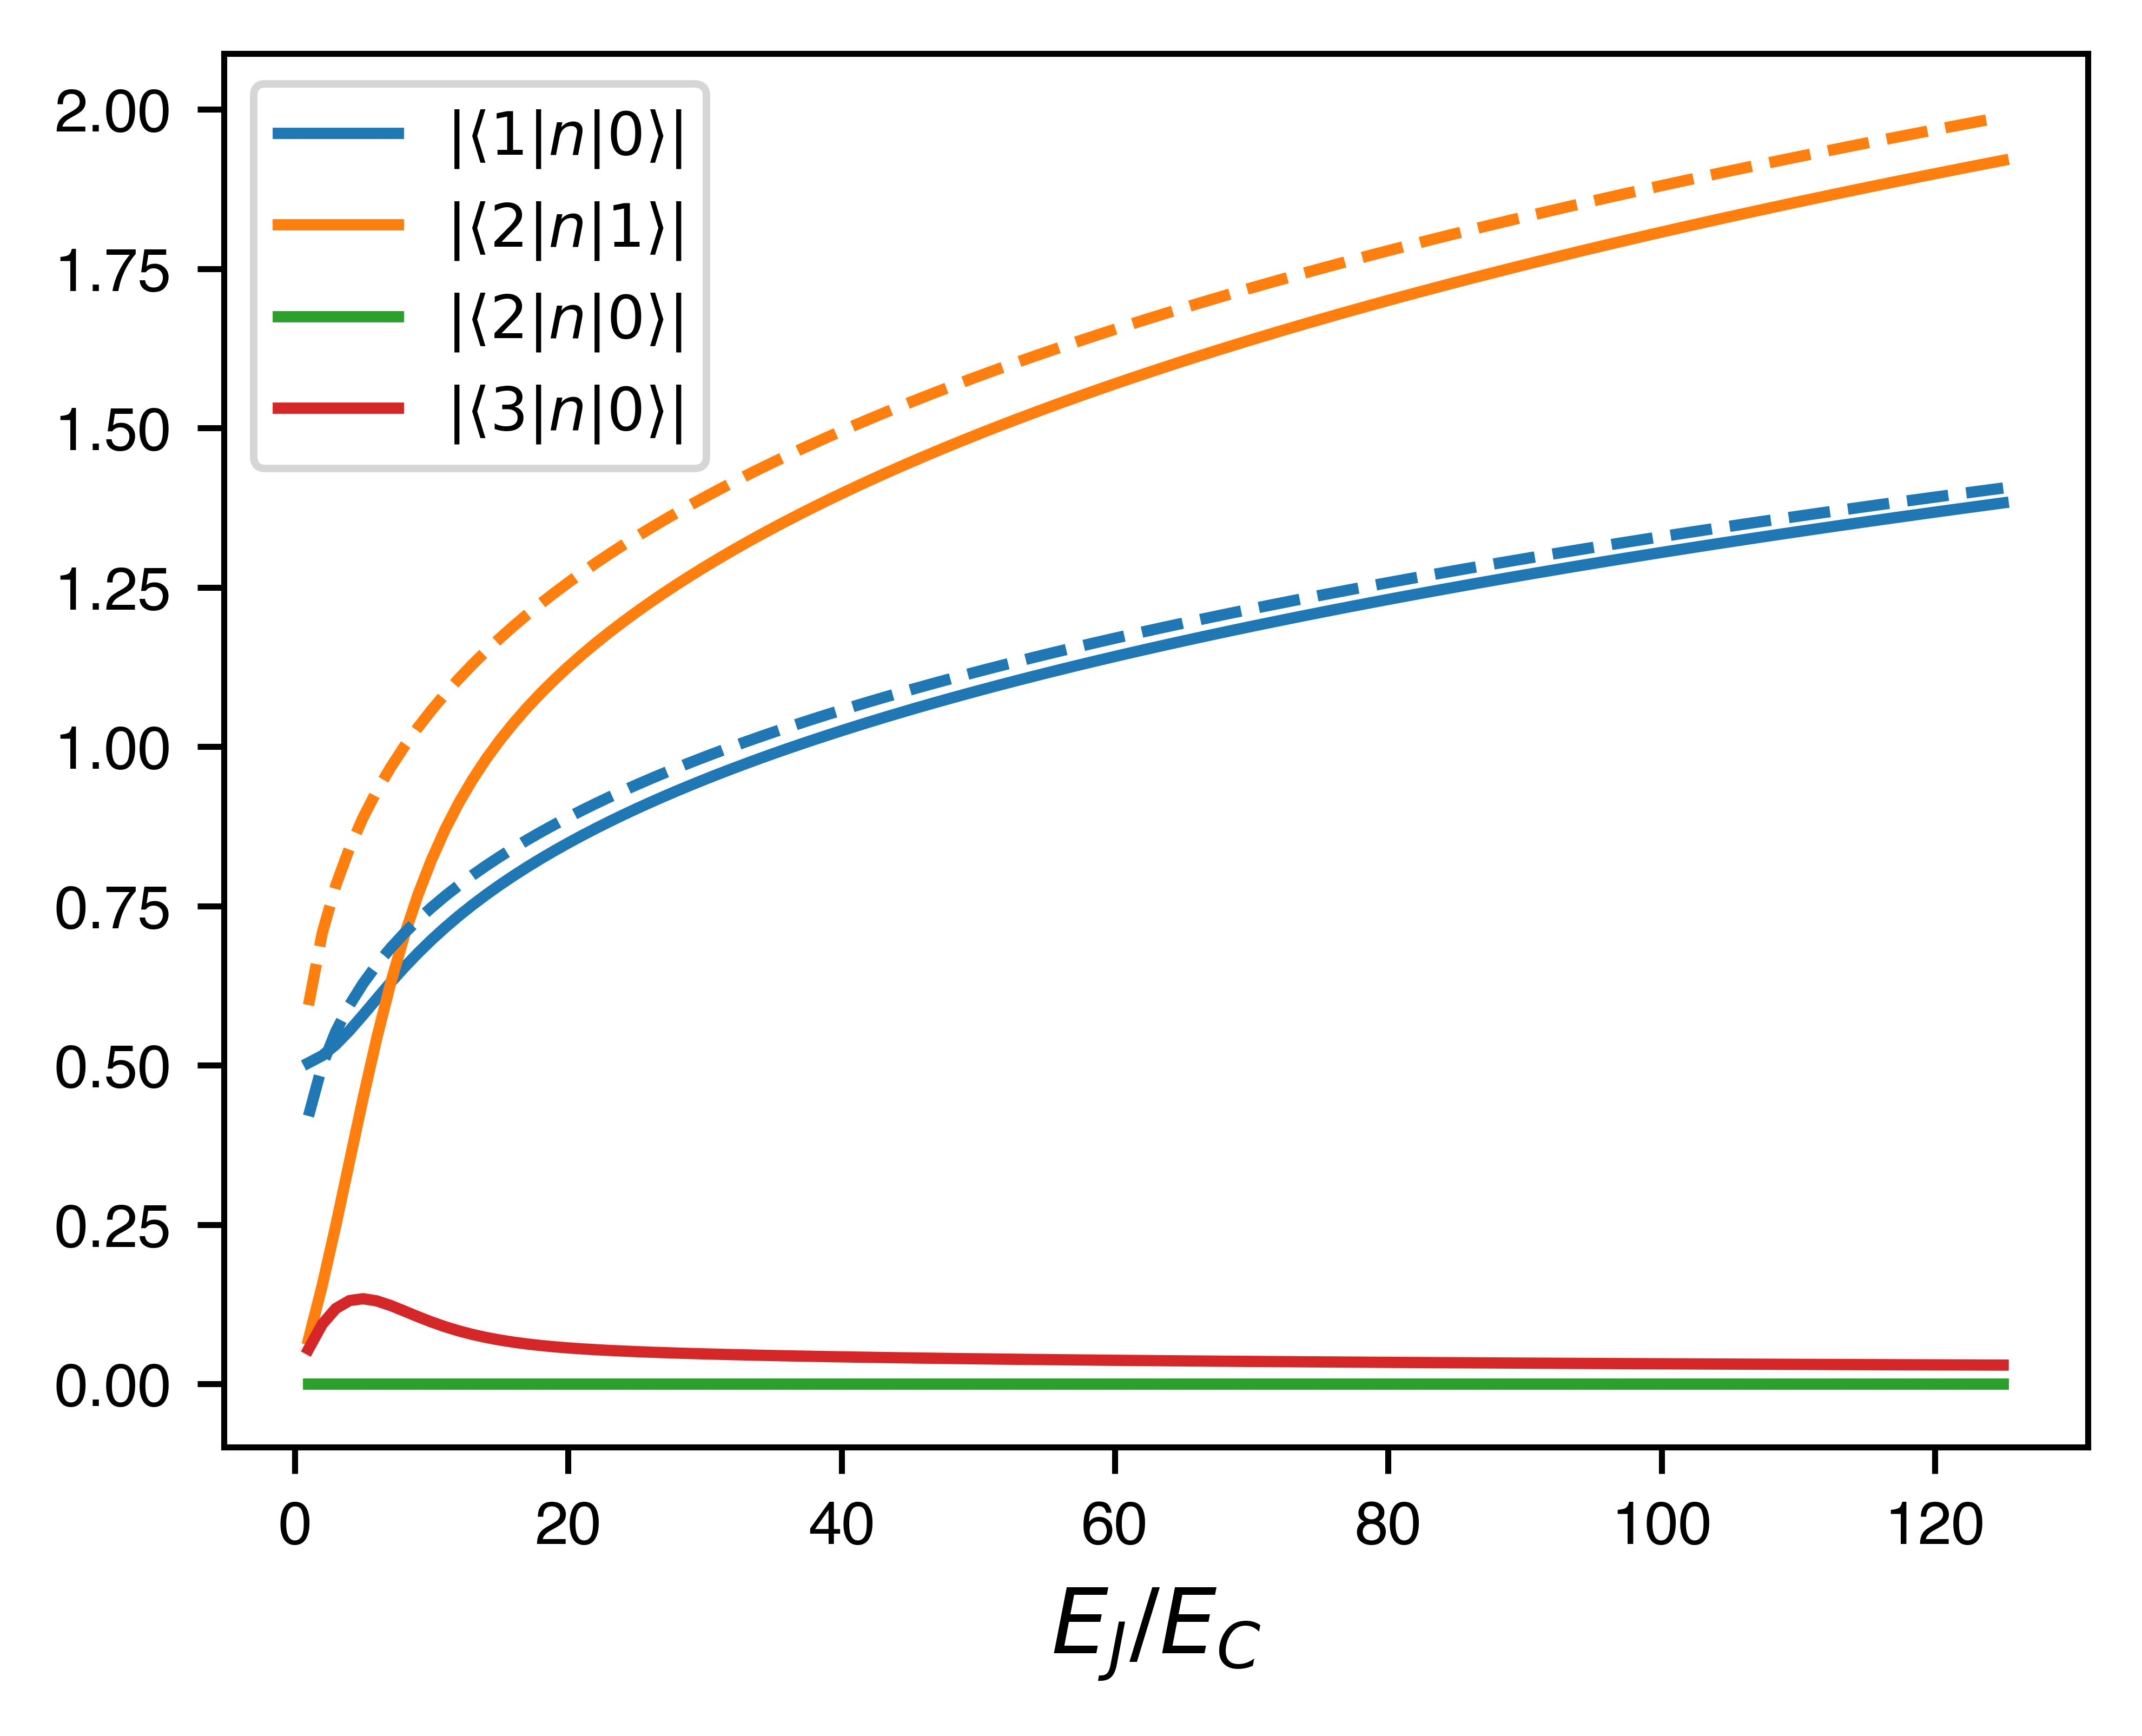

In [103]:
# Define the charge number operator Hamiltonian:
def nHat(nLevels):
    n = np.matrix(np.diag(np.arange(-nLevels, nLevels+1, 1)), dtype=complex)
    return n

def cosPhiHat(nLevels):
    cosPhi = np.matrix(np.diag(np.repeat(0.5, 2*nLevels), -1) + np.diag(np.repeat(0.5, 2*nLevels), -1).T, dtype=complex)
    return cosPhi

# Define the transmon Hamiltonian:
def hTransmon(EJ, EC, nG, nLevels):
    n = nHat(nLevels)
    cosPhi = cosPhiHat(nLevels)
    eye = np.matrix(np.diag(np.repeat(1, 1 + 2*nLevels)), dtype=complex)
    H = 4*EC*((n-(nG*eye))**2) - EJ*cosPhi
    return H

# Set the number of |n> states to be used in the simulation:
nLevels = 100 # Number of charge states considered (basis runs from -nLevels to nLevels)
nG = 0.5 # Value used in Koch 2007
n = nHat(nLevels) # Form of the n operator to be used in the evaluation of the matrix elements

EJ = 10e9 # Hz
EJoverEC_max = 125
EJoverECs = np.linspace(1, EJoverEC_max, EJoverEC_max, endpoint=True)
matEls = {
    '1n0' : np.zeros(EJoverEC_max),
    '2n0' : np.zeros(EJoverEC_max),
    '3n0' : np.zeros(EJoverEC_max),
    '2n1' : np.zeros(EJoverEC_max)
}

for i in range(EJoverEC_max):
    EJoverEC = EJoverECs[i]
    h = hTransmon(EJ, EJ/EJoverEC, nG, nLevels)
    energyEigVals, energyEigVecs = scipy.linalg.eigh(h)
    matEls['1n0'][i] = np.abs(energyEigVecs[:, 1].conj().T @ n @ energyEigVecs[:, 0])
    matEls['2n0'][i] = np.abs(energyEigVecs[:, 2].conj().T @ n @ energyEigVecs[:, 0])
    matEls['3n0'][i] = np.abs(energyEigVecs[:, 3].conj().T @ n @ energyEigVecs[:, 0])
    matEls['2n1'][i] = np.abs(energyEigVecs[:, 2].conj().T @ n @ energyEigVecs[:, 1])

fig, ax = plt.subplots(figsize=(4, 3.25), dpi=1000)
# Numerical (exact) solutions:
ax.plot(EJoverECs, matEls['1n0'], label='$| \\langle 1 | n | 0 \\rangle|$', color='C0')
ax.plot(EJoverECs, matEls['2n1'], label='$| \\langle 2 | n | 1 \\rangle|$', color='C1')
ax.plot(EJoverECs, matEls['2n0'], label='$| \\langle 2 | n | 0 \\rangle|$', color='C2')
ax.plot(EJoverECs, matEls['3n0'], label='$| \\langle 3 | n | 0 \\rangle|$', color='C3')
# Analytical (approximate) solutions:
ax.plot(EJoverECs, np.sqrt(1/2)*(((1/8)*EJoverECs)**0.25), color='C0', ls='dashed')
ax.plot(EJoverECs, ((1/8)*EJoverECs)**0.25, color='C1', ls='dashed')
ax.set_xlabel('$E_J / E_C$', fontsize=12)
ax.legend()
plt.tight_layout()
fig.savefig('fig3p3.pdf')

# Figure 3.4

This figure should display the dispersive shift of the transmon as a function of detuning (Fig 9 of Koch 2007).

/var/folders/m8/gbh7nps52zzfb187_b37kb540000gn/T/ipykernel_10556/871700965.py:37: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  n10 = np.asscalar(np.sqrt(np.abs(energyEigVecs[:, 1].conj().T @ n @ energyEigVecs[:, 0])))
/var/folders/m8/gbh7nps52zzfb187_b37kb540000gn/T/ipykernel_10556/871700965.py:38: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  n21 = np.asscalar(np.sqrt(np.abs(energyEigVecs[:, 2].conj().T @ n @ energyEigVecs[:, 1])))
/var/folders/m8/gbh7nps52zzfb187_b37kb540000gn/T/ipykernel_10556/871700965.py:21: RuntimeWarning: divide by zero encountered in true_divide
  result = 4 * beta**2 * ((n10**2 / detuning) - 0.5 * (n21**2 / (detuning + omega_ratio)))
/var/folders/m8/gbh7nps52zzfb187_b37kb540000gn/T/ipykernel_10556/871700965.py:21: RuntimeWarning: divide by zero encountered in true_divide
  result = 4 * beta**2 * ((n10**2 / detuning) - 0.5 * (n21**2 / (detuning + omega_ratio)))
/var/folde

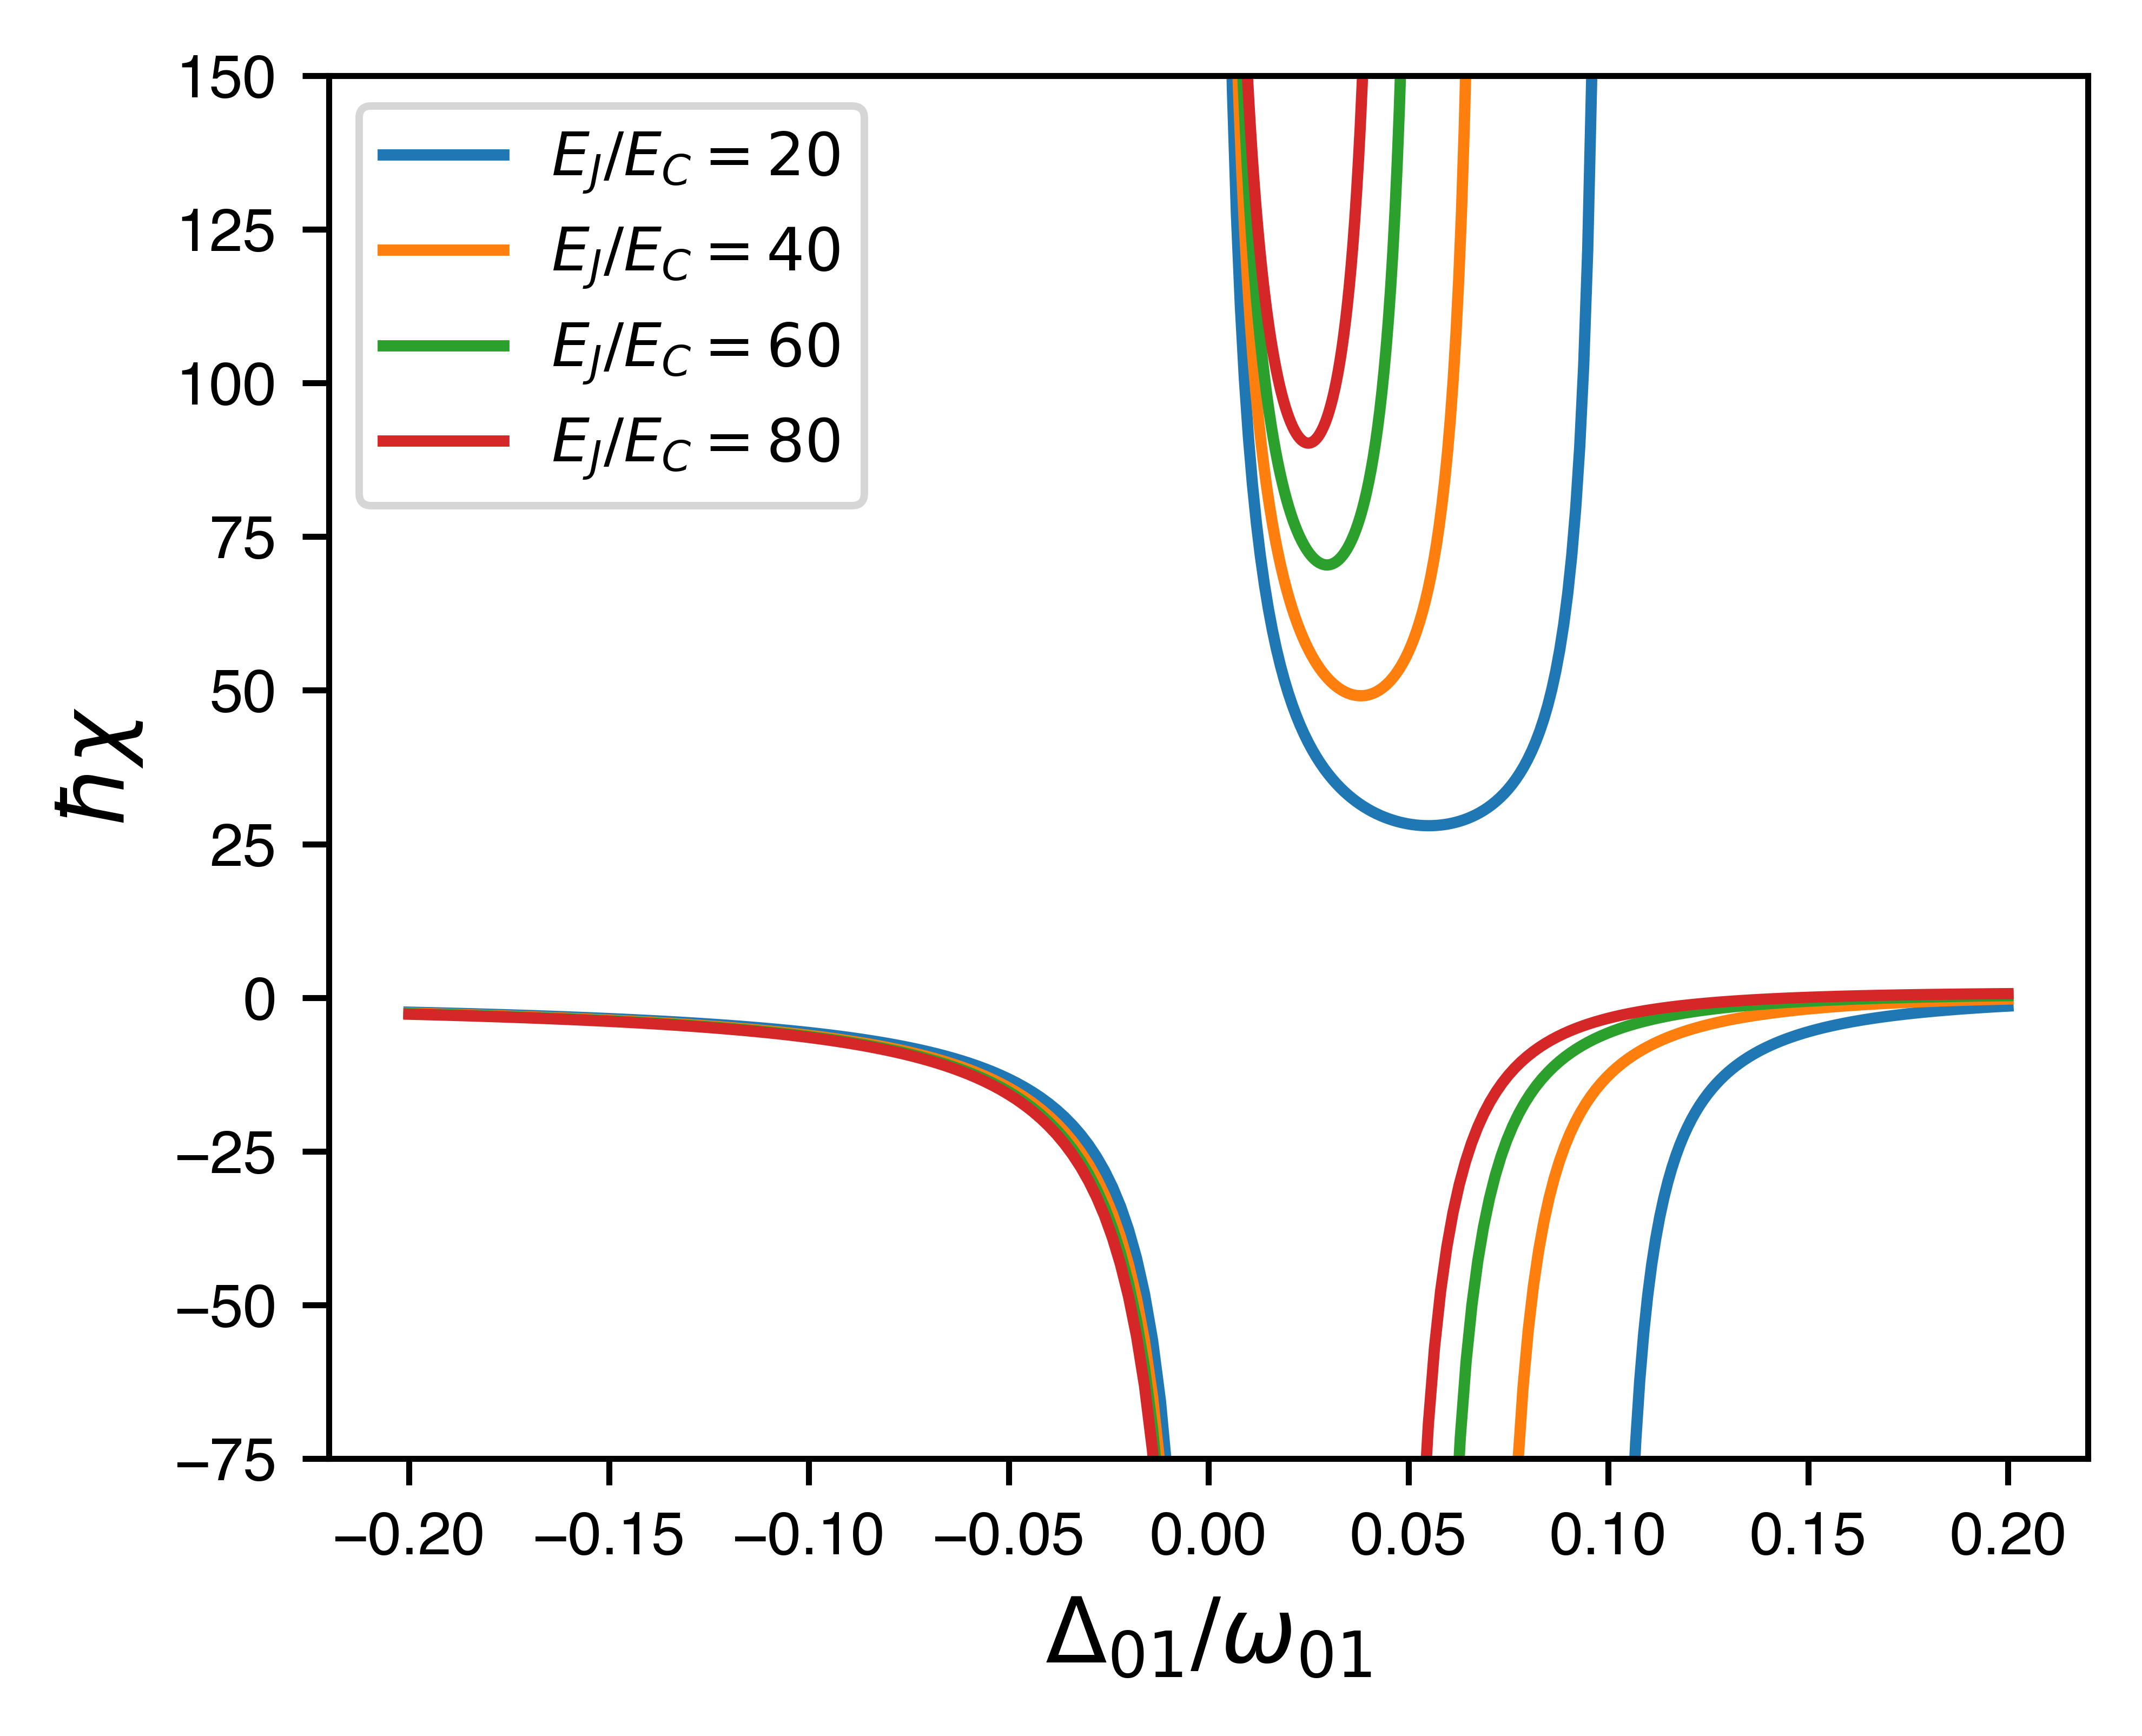

In [145]:
# Define the charge number operator Hamiltonian:
def nHat(nLevels):
    n = np.matrix(np.diag(np.arange(-nLevels, nLevels+1, 1)), dtype=complex)
    return n

def cosPhiHat(nLevels):
    cosPhi = np.matrix(np.diag(np.repeat(0.5, 2*nLevels), -1) + np.diag(np.repeat(0.5, 2*nLevels), -1).T, dtype=complex)
    return cosPhi

# Define the transmon Hamiltonian:
def hTransmon(EJ, EC, nG, nLevels):
    n = nHat(nLevels)
    cosPhi = cosPhiHat(nLevels)
    eye = np.matrix(np.diag(np.repeat(1, 1 + 2*nLevels)), dtype=complex)
    H = 4*EC*((n-(nG*eye))**2) - EJ*cosPhi
    return H

def chi(detuning, beta, n10, n21, omega10, omega21):
    detuning = np.asarray(detuning).flatten()  # Ensure detuning is 1D
    omega_ratio = (omega21 - omega10) / omega10  # Scalar calculation
    result = 4 * beta**2 * ((n10**2 / detuning) - 0.5 * (n21**2 / (detuning + omega_ratio)))
    return np.squeeze(result)  # Ensure output is 1D

nLevels = 100 # Number of charge states considered (basis runs from -nLevels to nLevels)
nG = 0.5 # Value used in Koch 2007
beta = 0.5 # Value used in Koch 2007
n = nHat(nLevels) # Form of the n operator to be used in the evaluation of the matrix elements
EJ = 10e9 # Hz
EJoverECs = [20, 40, 60, 80]
detunings = np.linspace(-0.2, 0.2, 101, endpoint=True)

fig, ax = plt.subplots(figsize=(4, 3.25), dpi=1000)
ax.set_ylim([-75, 150])
for i, EJoverEC in enumerate(EJoverECs):
    h = hTransmon(EJ, EJ/EJoverEC, nG, nLevels)
    energyEigVals, energyEigVecs = scipy.linalg.eigh(h)
    n10 = np.asscalar(np.sqrt(np.abs(energyEigVecs[:, 1].conj().T @ n @ energyEigVecs[:, 0])))
    n21 = np.asscalar(np.sqrt(np.abs(energyEigVecs[:, 2].conj().T @ n @ energyEigVecs[:, 1])))
    omega10 = energyEigVals[1] - energyEigVals[0]
    omega21 = energyEigVals[2] - energyEigVals[1]
    omega_ratio = (omega10 - omega21) / omega10
    detunings1 = np.linspace(-0.2, 0, 101, endpoint=True)
    detunings2 = np.linspace(0, omega_ratio, 101, endpoint=True)
    detunings3 = np.linspace(omega_ratio, 0.2, 101, endpoint=True)
    # Plot each segment separately
    ax.plot(detunings1, chi(detunings1, beta, n10, n21, omega10, omega21), label='$E_J/E_C = %d$' % EJoverEC, color=f'C{i}')
    ax.plot(detunings2, chi(detunings2, beta, n10, n21, omega10, omega21), color=f'C{i}')
    ax.plot(detunings3, chi(detunings3, beta, n10, n21, omega10, omega21), color=f'C{i}')
    
ax.set_xlabel('$\\Delta_{01} / \\omega_{01}$', fontsize=12)
ax.set_ylabel('$\\hbar \\chi$', fontsize=12)
ax.legend()
plt.tight_layout()
fig.savefig('fig3p4.pdf')

# Figure 3.5

Ulysses and the Sirens

# Figure 3.6

Model for capacitive loss (capacitance C and resistor R in series, where associated with the top node is a charge q, and the capacitor is above the resistor).

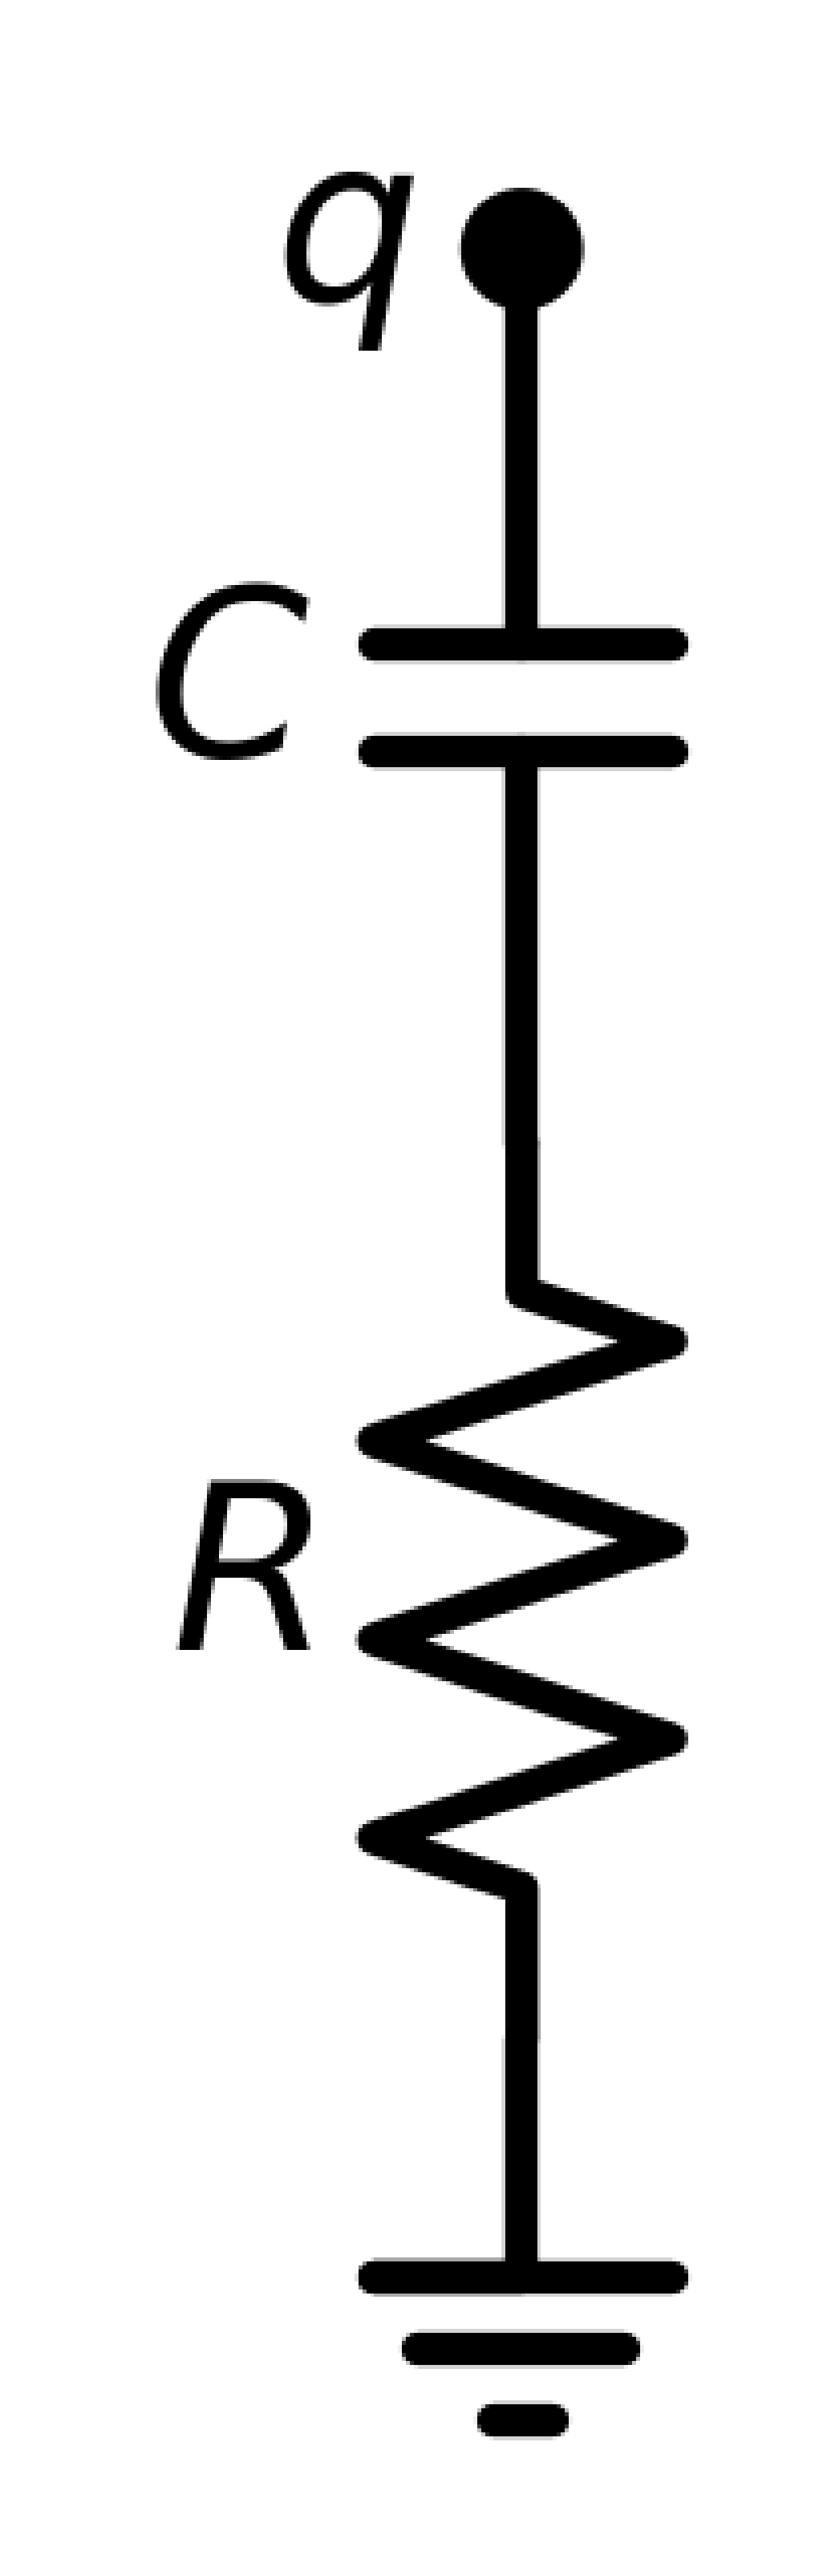

In [68]:
# Create a new drawing
d = schemdraw.Drawing()

d += elm.Dot().label("$q$", loc="left")
d += elm.Capacitor().down().label("$C$").length(1.5)
d += elm.Resistor().down().label("$R$").length(1.5)
d += elm.Ground()

d.draw()

d.save("capacitiveLoss.png", dpi=300)

# Load the saved image and integrate it into a matplotlib figure
img = Image.open("capacitiveLoss.png")

fig, ax = plt.subplots(figsize=(3.25, 3.25), dpi=1000)

ax.imshow(img)
ax.axis('off')  # Hide axes for a clean look
plt.tight_layout()
plt.savefig("fig3p6.pdf")

# Figure 3.7

Model for inductive loss (capacitance L and conductance G in series, where associated with the top node is a flux phi, and the inductor is to the left of the conductance).

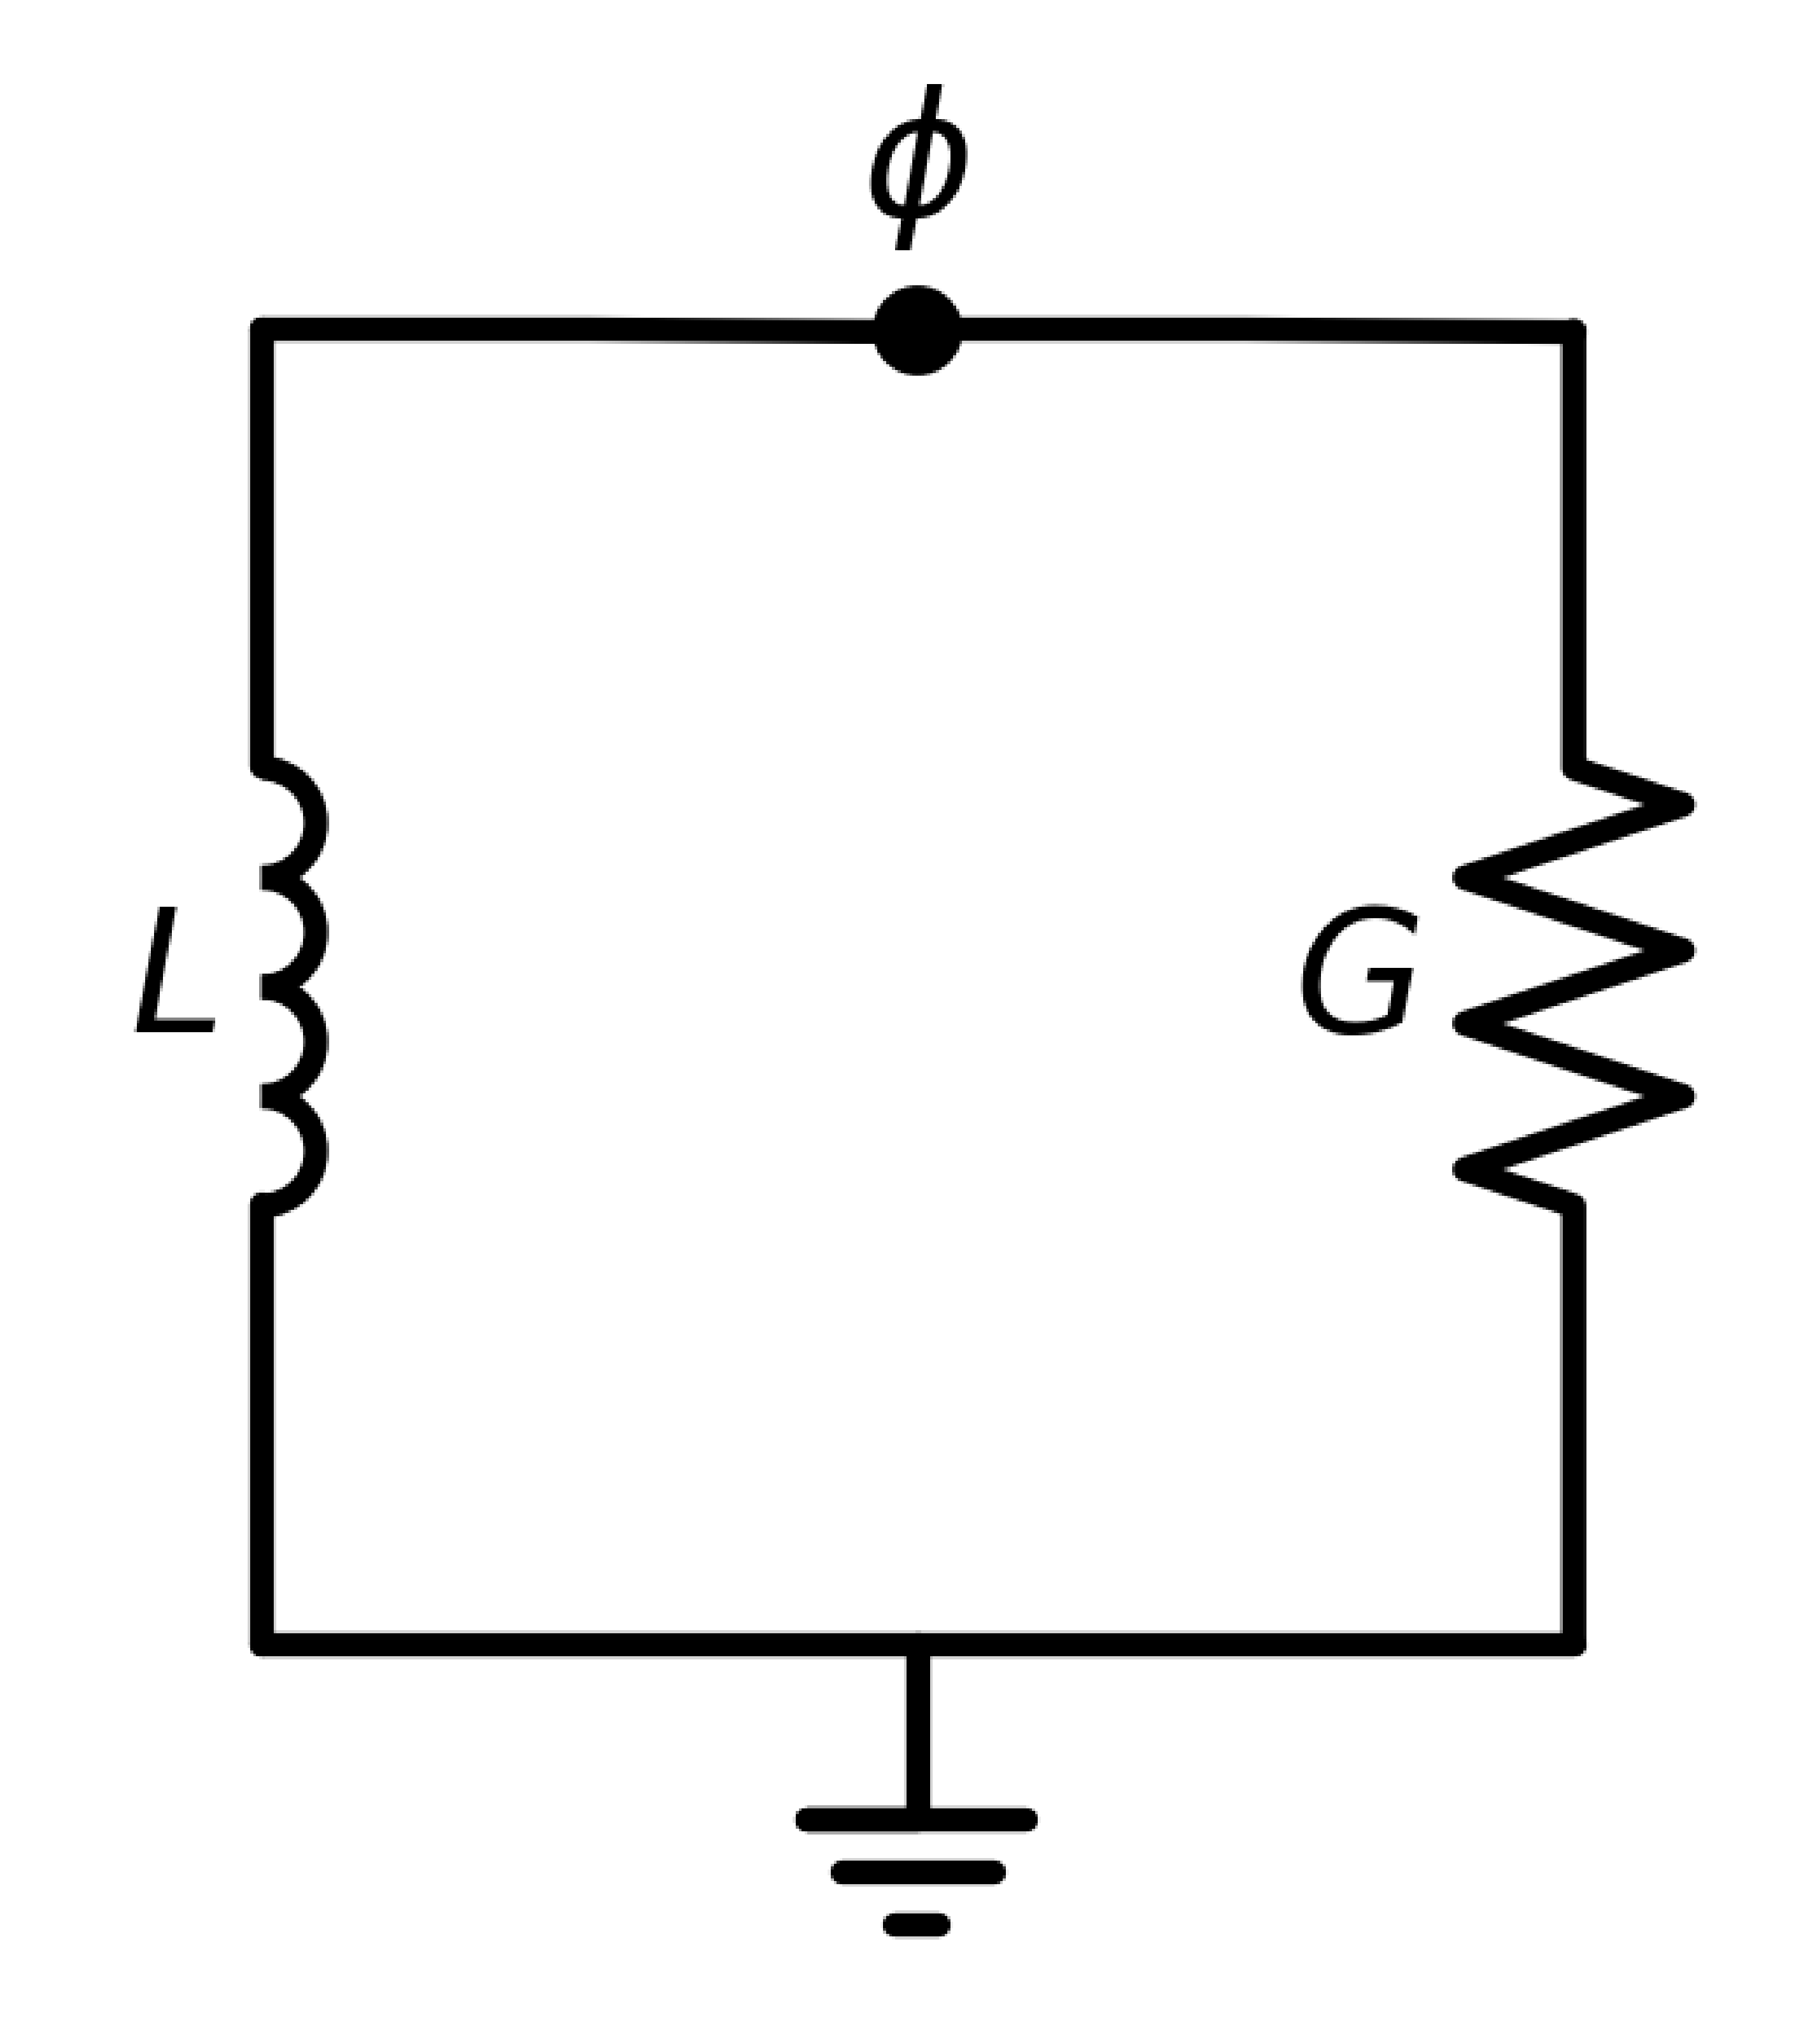

In [69]:
# Create a new drawing
d = schemdraw.Drawing()

d += elm.Dot().label("$\phi$", loc="top")
d += elm.Line().left().length(1.5)
d += elm.Inductor().down().label("$L$")
d += elm.Line().right().length(1.5)
d += elm.Ground()
d += elm.Line().right().length(1.5)
d += elm.Resistor().up().label("$G$")
d += elm.Line().left().length(1.5)

# d.draw()

d.save("inductiveLoss.png", dpi=300)

# Load the saved image and integrate it into a matplotlib figure
img = Image.open("inductiveLoss.png")

fig, ax = plt.subplots(figsize=(3.25, 3.25), dpi=1000)

ax.imshow(img)
ax.axis('off')  # Hide axes for a clean look
plt.tight_layout()
plt.savefig("fig3p7.pdf")

# Plot of spectral noise densities

Charge noise:

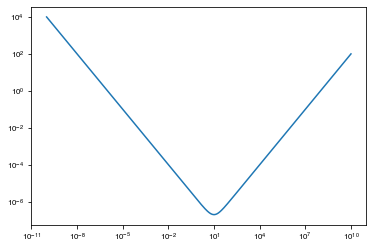

In [11]:
eCharge = 1.60217663e-19
AQ = 1e-3
BQ = 1e-4
def sCharge(f):
    lf = (AQ**2)/f
    hf = (BQ**2)*f
    return hf + lf
    
f = np.logspace(-10, 10, 1000)
plt.plot(f, sCharge(f))
plt.xscale('log')
plt.yscale('log')

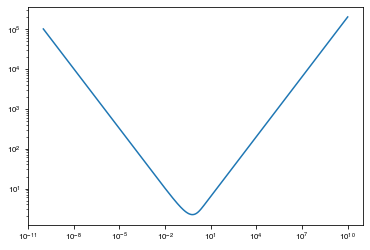

In [24]:
def sIdeal(f):
#     return (f*((1/np.tanh(f))+1)) + (1/f)
    return (f**0.5)*((1/np.tanh(f))+1)

f = np.logspace(-10, 10, 1000)
plt.plot(f, sIdeal(f))
plt.xscale('log')
plt.yscale('log')